<a href="https://colab.research.google.com/github/almiab1/MUIIADeepLearning/blob/main/PracticaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Final | Deep Learning

En el presente trabajo se proponen dos modelos basados en redes convolucionales, los cuales se trata de clasificar correctamente si un individuo está parpadeando o no. En la actualidad se pueden encontrar modelos de gran calidad, los cuales permiten construir modelos de gran precisión basándose sobre la base de dichos modelos pre-entrenados. Por ello, los modelos propuestos en este trabajo se definen haciendo uso de modelos previamente entrenados.

En primer lugar, se propone una red basada en el modelo `InceptionResNetV2`. Un modelo pesado de gran profundidad que proporciona buenos resultados en problemas de clasificación. Se propone una estrategia donde el modelo `InceptionResNetV2` toma la función de extractor de características, obteniendo así las características profundas que posteriormente podrán ser utilizadas en la clasificación de las imágenes. En segundo punto, se propone una red basada en el modelo `DenseNet`. Un modelo de menor tamaño y que permite obtener resultados similares a los de `InceptionResNetV2`. En este caso se trata de re-entrenar el clasificador y aplicando `fine tuning` con el fin de ajustar los parámetros del modelo.

Dado que se parte de un conjunto de datos desbalanceado, es necesario aplicar algunos métodos de balanceo con el fin de obtener un modelo más robusto. Previamente, al entrenamiento de la red, se propone el uso de técnicas como la estratificación de datos o `data augmentation`. A su vez, para mejorar el proceso de entrenamiento se hace empleo de `mini-batches` y de optimizadores como el optimizador Adam.

In [1]:
# Data manipulation and linear algebra
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

# Neural network API
from sklearn.model_selection import train_test_split

# Keras imports
from tensorflow.keras import optimizers, Input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.applications import InceptionResNetV2, DenseNet169 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install -U tensorflow-addons
from tensorflow_addons.metrics import F1Score

/Users/aijutic/miniconda3/envs/cnnDL/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
_isColab = False

if _isColab:
    from google.colab import drive

    # Montamos el Google Drive en el directorio del proyecto y descomprimios el fichero con los datos
    drive.mount('/content/drive')
    !unzip -n '/content/drive/MyDrive/UIMP/Asignaturas/5-DeepLearning/Practicas/Final/Source/RT-BENE.zip' >> /dev/null

## Pasos previos

En esta sección se realizando las actuaciones previas, tales como la carga del conjunto de datos y la creación de los distintos subconjuntos de datos que van a ser usados en la entramiento y validación del modelo.

### Preparar el conjunto de datos

* **Cargar el dataset en el colab**

In [3]:
# Especificamos los paths al directorio que contiene las imagenes y al fichero con las etiquetas
data_path = 'RT-BENE/'

if _isColab == False:
    data_path = "./../RT-BENE/"

imgs_path = data_path + "images/"
labels_path = data_path + "blinks.csv"


# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path, dtype = {"blink": "category"})

# Mostramos los primero elementos del dataset
labels.head()

,blink_id,left_eye,right_eye,video,blink
0,0,0_left_000001_rgb.png,0_right_000001_rgb.png,0,0
1,1,0_left_000002_rgb.png,0_right_000002_rgb.png,0,0
2,2,0_left_000003_rgb.png,0_right_000003_rgb.png,0,0
3,3,0_left_000004_rgb.png,0_right_000004_rgb.png,0,0
4,4,0_left_000005_rgb.png,0_right_000005_rgb.png,0,0


Con el fin de tener una idea de las imágenes que se tratan, se muestran dos ejemplos:

- Dos imágenes correspondientes al ojo derecho e izquierdo sin parpadear
- Dos imágenes correspondientes al ojo derecho e izquierdo parpadeando

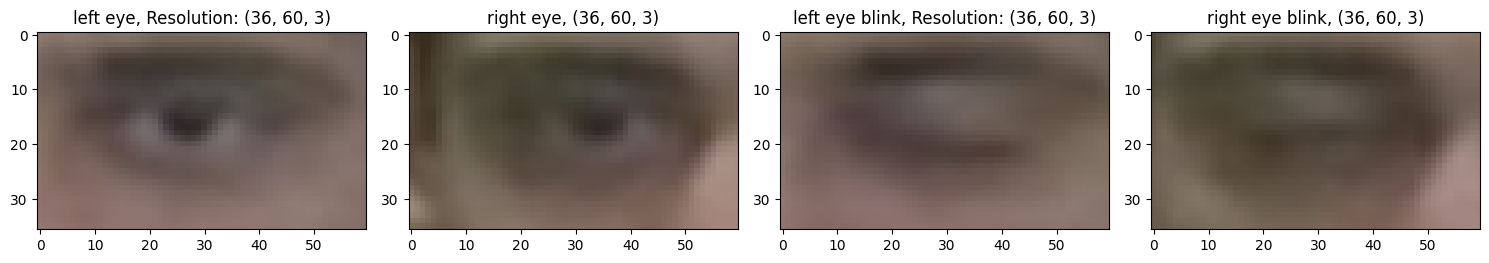

In [4]:
fig, ax = plt.subplots(1,4, figsize=(15,8))
# Cataract Image
left_eye_1 = mpimage.imread(f'{imgs_path}/0_left_000001_rgb.png')
ax[0].imshow(left_eye_1)
ax[0].set_title(f'left eye, Resolution: {left_eye_1.shape}')

# Diabetic_retinopathy
right_eye_1 = mpimage.imread(f'{imgs_path}/0_right_000001_rgb.png')
ax[1].imshow(right_eye_1)
ax[1].set_title(f'right eye, {right_eye_1.shape}')

# Glaucoma Image
left_eye_2 = mpimage.imread(f'{imgs_path}/0_left_000161_rgb.png')
ax[2].imshow(left_eye_2)
ax[2].set_title(f'left eye blink, Resolution: {left_eye_2.shape}')

# Normal Image
right_eye_2 = mpimage.imread(f'{imgs_path}/0_right_000161_rgb.png')
ax[3].imshow(right_eye_2)
ax[3].set_title(f'right eye blink, {right_eye_2.shape}')

plt.tight_layout()
plt.show()

### Desbalanceo de clases

Los parpadeos son acciones rapidas y espontáneas que duran pocos segundos, por lo que en el conjunto de datos existen pocos fotogramas anotados como parpadeos. Esto implica que el conjunto está desequilibrado. 

In [ ]:
# Clase blink: 0 no parpadea - 1 parapdeo
blink = labels[-1]

plt.hist(blink,bins=2)

- **Creamos las tres particiones de datos: entrenamiento, validación y test**

In [5]:
# Semilla para replicar los experimentos
seed = 2023

# Creamos las tres particiones de datos: entrenamiento, validación y test aplicando estratificación
train_data, test_data = train_test_split(labels, test_size=0.2, stratify=labels["blink"], random_state=seed)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data["blink"], random_state=seed)

En Keras no existen generadores por defecto que devuelvan dos imágenes. Necesitamos crear nuestro propio generador que devuelva a la vez las imágenes de ambos ojos y la etiqueta del frame. Para ello podemos crear dos generadores (uno para cada ojo) usando el método `flow_from_databrame` y combinarlos para crear el generador deseado.

Para abordar el desequilibrio de clases, se hace uso de la técnica de generación de datos artificiales, conocida como "*data augmentation*". La biblioteca Keras proporciona una clase llamada ImageDataGenerator que puedes utilizar para generar imágenes adicionales con ligeras variaciones.

In [6]:
# Aplicar tecnicas de preprocesado
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=10, # rotación aleatoria en un rango de 20 grados
                             width_shift_range=0.1, # desplazamiento horizontal aleatorio en un rango del 10% de la anchura de la imagen
                             height_shift_range=0.1, # desplazamiento vertical aleatorio en un rango del 10% de la altura de la imagen
                             zoom_range=0.1, # zoom aleatorio en un rango del 10%
                             horizontal_flip=True, # reflejo horizontal aleatorio
                             vertical_flip=False, # reflejo horizontal aleatorio
                             fill_mode='nearest')  # Relleno de píxeles cuando se produce una transformación

# datagen.fit(train_data)

# Columnas dataset
left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

# Parámetros
batch_size = 128
img_width = 122 # minimo 75x75
img_height = 75

# Generador custom que devuelve las dos imagenes de ojos y el label del parpadeo
def generator(dataframe):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe, 
                                                    directory = imgs_path, 
                                                    target_size =(img_width, img_height), 
                                                    x_col=left_eye_col, 
                                                    y_col=y_col, 
                                                    class_mode="binary", 
                                                    seed=seed, 
                                                    batch_size=batch_size)
  
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                    directory = imgs_path,
                                                    target_size =(img_width, img_height),
                                                    x_col=right_eye_col,
                                                    y_col=y_col,
                                                    class_mode="binary",
                                                    seed=seed,
                                                    batch_size=batch_size)
  
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

# Llamada a la función generator
train_generator = generator(train_data)
val_generator = generator(val_data)
test_generator = generator(test_data)

- **Definición de parámetros comunes**

In [7]:
"""" Configuraciones previas """

# Definimos la métrica F1
f1_score = F1Score(name="f1_score", num_classes=1, threshold=0.5, average='macro')

# Declaramos dos capas de Input
input_shape = (img_width,img_height,3)

input_image1 = Input(shape=input_shape)
input_image2 = Input(shape=input_shape)

# Definimos el ratio de aprendizaje
lr = 1e-4

Metal device set to: Apple M1 Ultra

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



## Trasnfer learing con InceptionResNetV2 como extractor de características

El primer modelo que se contruye esta conformado sobre la base del modelo pre-entrenado **InceptionResNetV2**, disponible a traves de la libreria **keras**. **InceptionResNetV2** tiene un tamaño de 80 MB, ha sido entrenado con 555.9 millones de parámetros y tiene una profuncidad de 449 capas. Respecto a la precisión del mismo, presenta un 95.3% de precisión para el dataset de validación de ImageNet.

 

Antes de entrenar el modelo, es importante decidir qué capas se actualizarán durante el entrenamiento. Para este caso, como se va a hacer uso de **InceptionResNetV2** como extractor de características, se marcan todas las capas del modelo como no entrenables.

[1] Blabla

In [8]:
# Cargar InceptionResNetV2 pre-entrenado en ImageNet, sin la capa final
base_model_incept = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

# Congelar todas las capas del modelo base para aplicar transfer learning
for layer in base_model_incept.layers:
    layer.trainable = False

# Extraer las características utilizando InceptionResNetV2
features_image1 = base_model_incept(input_image1)
features_image2 = base_model_incept(input_image2)

# Combinar las características de ambas imágenes
merged_features = Concatenate()([features_image1, features_image2])

# Añadir capas adicionales para la clasificación
x = Dense(1024, activation='relu')(merged_features)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Crear el modelo
model_incept = Model(inputs=[input_image1, input_image2], outputs=output)

# Compilar el modelo
model_incept.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Imprimir un resumen del modelo
model_incept.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 122, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 122, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 1536)        54336736    ['input_1[0][0]',                
 l)                                                               'input_2[0][0]']            

Una vez definido el modelo se procede a ajustarlo mediante el método `fit`. A tra ves de dicho modelo se prodrá especificar tanto el numero de *epochs*, el numero de *baches* asi como especificar que conjunto de datos se hará uso como conjunto de validación. En este caso se añade el método **Early Stopping** con el fin de acelerar el entremaniento del modelo.

In [ ]:
# Configuración del método 'Early stopping'
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
n = 5

# Entrenamos el modelo con los datos preparados en el punto 2
model_incept.fit(train_generator,
          epochs=10,  # numero de epochs
          verbose=2,  # muestra informacion del error al finalizar cada epoch
          steps_per_epoch=len(train_data)/batch_size,
          validation_data=train_generator,
          validation_steps=len(val_data)/batch_size,
          callbacks=[early_stopping], # Añadir el callback de 'early stoppoing'
          class_weight={0: 1, 1: n}) # n es un número que indica cuánto más importante es la clase minoritaria. 

Después del entrenamiento, evalúa el rendimiento del modelo en el conjunto de prueba:

In [ ]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
test_loss, test_acc, test_f1_score = model_incept.evaluate(test_generator, steps=len(test_data) / batch_size, verbose=1)
print(f"Test_loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}, Test_F1_Score: {test_f1_score:.4f}")

Además de analizar el error obtenido, podemos utilizarlo para hacer predicciones. Para ello utilizaremos el método `predict`, al que le suministremos los datos de entrada.

In [ ]:
# Obtenemos las predicciones para todos los ejemplos del conjunto de test
# predictions = model_incept.predict(test_generator, verbose=1)

# Imprimimos la predicción obtenida para los dos primeros ejemplos
# Los valores obtenidos representan las probabilidades para cada una de las 5 clases
# for i in range(0,2):
#   print("\n Ejemplo", i)
#   print("\t Probabilidades para las 5 clases:", predictions[i])
#   print("\t Clase predicha: %i, Probabilidad: %.4f" % (np.argmax([predictions[i]]), np.max(predictions[i])))

## Fine Tuning con DenseNet

En este caso se hace uso del modelo **DenseNet121**. Este tiene un tamaño de 80 MB, ha sido entrenado con 20.1 millones de parámetros y tiene una profuncidad de 402 capas. Respecto a la precisión del mismo, presenta un 93.6% de precisión para el dataset de validación de ImageNet.

In [ ]:
# Cargar el modelo DenseNet121 pre-entrenado en ImageNet sin incluir la capa de salida
base_model_densenet = DenseNet169(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Congelar todas las capas del modelo base
for layer in base_model_densenet.layers:
    layer.trainable = False

# Descongelar las últimas capas para aplicar fine-tuning
# (en este ejemplo, descongelamos las últimas 50 capas)
for layer in base_model_densenet.layers[-50:]:
    layer.trainable = True

# Añadir una capa de GlobalAveragePooling2D
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)

# Añadir una capa Dense de salida con una función de activación sigmoide (clasificación binaria)
output = Dense(1, activation='sigmoid')(x)

# Crear el nuevo modelo
model_dn = Model(inputs=[input_image1, input_image2], outputs=output)

# Compilar el modelo con la función de pérdida binary_crossentropy y la métrica de precisión
model_dn.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

- Entrenar el modelo

In [ ]:
# Configuración del método 'Early stopping'
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamos el modelo con los datos preparados en el punto 2
model_dn.fit(train_generator,
          epochs=10,  # numero de epochs
          verbose=2,  # muestra informacion del error al finalizar cada epoch
          steps_per_epoch=len(train_data)/batch_size,
          validation_data=train_generator,
          validation_steps=len(val_data)/batch_size,
          callbacks=[early_stopping]) # Añadir el callback de 'early stoppoing'

Después del entrenamiento, evalúa el rendimiento del modelo en el conjunto de prueba:

In [ ]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
test_loss, test_acc, test_f1_score = model_dn.evaluate(test_generator, steps=len(test_data) / batch_size, verbose=1)
print(f"Test_loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}, Test_F1_Score: {test_f1_score:.4f}")

Además de analizar el error obtenido, podemos utilizarlo para hacer predicciones. Para ello utilizaremos el método `predict`, al que le suministremos los datos de entrada.

In [ ]:
# Obtenemos las predicciones para todos los ejemplos del conjunto de test
# predictions = model_incept.predict(test_generator, verbose=1)

# Imprimimos la predicción obtenida para los dos primeros ejemplos
# Los valores obtenidos representan las probabilidades para cada una de las 5 clases
# for i in range(0,2):
#   print("\n Ejemplo", i)
#   print("\t Probabilidades para las 5 clases:", predictions[i])
#   print("\t Clase predicha: %i, Probabilidad: %.4f" % (np.argmax([predictions[i]]), np.max(predictions[i])))